In [2]:
import numpy as np
import pandas as pd
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
file_path = "C:/Users/choud/OneDrive/Desktop/Code/Quantum-Boltzmann-Machine-QBM-for-Financial-Market-Prediction/dataset_MRK_prediction.csv"
df = pd.read_csv(file_path)

In [4]:
# Preprocess dataset
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
# Define features (X) and target (Y)
X = df.drop(columns=['Close_lead1'])
y = df['Close_lead1']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [7]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Define a quantum device (simulated)
num_qubits = 4  # Adjust based on feature complexity
dev = qml.device("default.qubit", wires=num_qubits)


In [10]:
@qml.qnode(dev)
def qbm_circuit(params):
    for i in range(num_qubits):
        qml.RX(params[i], wires=i)  # Apply rotation on each qubit
        qml.RY(params[i + num_qubits], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [11]:
# Print the QBM circuit
print(qml.draw(qbm_circuit)(np.random.uniform(0, np.pi, size=(2 *num_qubits,))))

0: ──RX(0.51)──RY(1.35)─┤  <Z>
1: ──RX(2.35)──RY(2.61)─┤  <Z>
2: ──RX(0.70)──RY(2.86)─┤  <Z>
3: ──RX(2.51)──RY(2.60)─┤  <Z>


In [12]:
# Generate quantum features
def generate_qbm_features(X):
    np.random.seed(42)
    params = np.random.uniform(0, np.pi, size=(2 * num_qubits,))
    qbm_features = np.array([qbm_circuit(params) for _ in range(len(X))])
    return qbm_features

In [13]:
# Get QBM-enhanced features
qbm_train_features = generate_qbm_features(X_train_scaled)
qbm_test_features = generate_qbm_features(X_test_scaled)

# Merge QBM features with original dataset
X_train_final = np.hstack((X_train_scaled, qbm_train_features))
X_test_final = np.hstack((X_test_scaled, qbm_test_features))

In [14]:
# -------------------------
# ✅ Train Linear Regression Model
# -------------------------

lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train)
y_pred = lr_model.predict(X_test_final)


In [15]:
# -------------------------
# 📊 Evaluate Model Performance
# -------------------------

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n🔍 {model_name} Performance:")
    print(f"   - MAE: {mae:.4f}")
    print(f"   - RMSE: {rmse:.4f}")
    print(f"   - R² Score: {r2:.4f}")
    return mae, rmse, r2

evaluate_model(y_test, y_pred, "Linear Regression with QBM")


🔍 Linear Regression with QBM Performance:
   - MAE: 0.9735
   - RMSE: 1.3110
   - R² Score: 0.9750


(0.9734600425234331, np.float64(1.31100418959748), 0.9749567295878192)

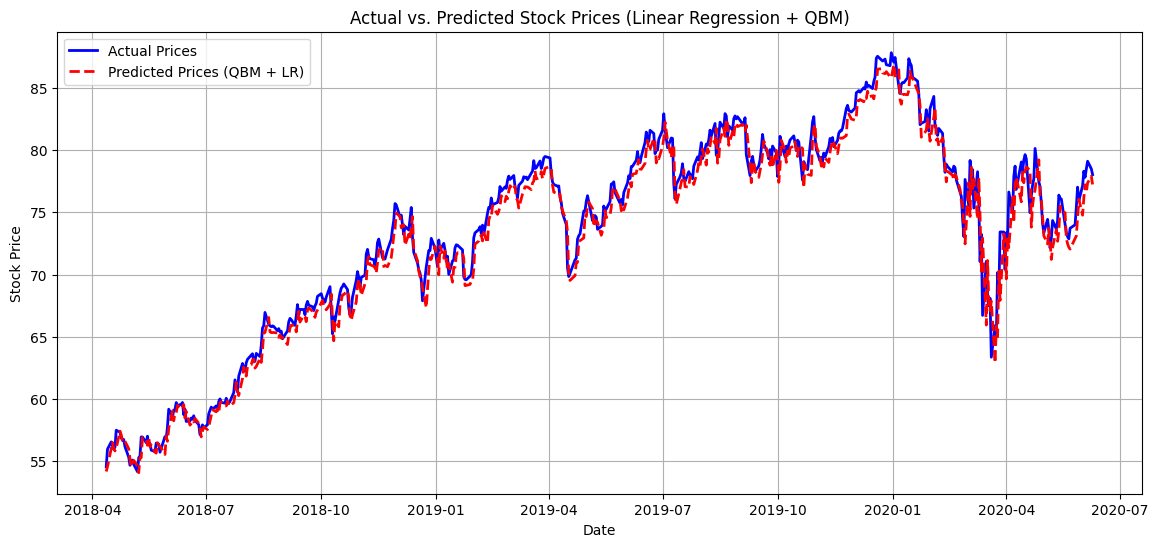

In [16]:
# -------------------------
# 📈 Plot Results: Actual vs Predicted
# -------------------------

plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test.values, label="Actual Prices", color="blue", linewidth=2)
plt.plot(y_test.index, y_pred, label="Predicted Prices (QBM + LR)", color="red", linestyle="--", linewidth=2)
plt.title("Actual vs. Predicted Stock Prices (Linear Regression + QBM)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()